In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from tqdm.notebook import tqdm_notebook
#from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
#from scipy.optimize import curve_fit
from tqdm import tqdm

# Read data

In [2]:
df = pd.read_csv('./Blanco1_10.csv')
df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
#c_pm = (df['pmra'] > -30) & (df['pmra'] < 0) & (df['pmdec'] > 0) & (df['pmdec'] < 30)
#df = df[c_pm]
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)
df

(66454, 19)


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,g,g_error,rp,rp_error,bp,bp_error,dr2_radial_velocity,dr2_radial_velocity_error
0,2361244720077776000,4.464920,0.014703,-22.003904,0.011957,0.002227,0.000017,33.444519,0.016970,-5.186394,0.014139,12.076946,64.895660,11.561395,84.866295,12.424769,117.260230,-12.706180,0.768446
1,2361244896172263168,4.509913,0.014585,-21.972946,0.010695,0.002178,0.000016,-0.433714,0.016601,-15.101542,0.011985,13.471384,13.826250,12.901414,96.861860,13.843132,123.025750,0.000000,0.000000
2,2339421510210638592,-3.638017,0.066035,-23.288158,0.072808,0.002716,0.000084,-17.049345,0.095646,-4.279699,0.082596,16.829458,3.398628,15.789721,15.016044,17.948673,20.249504,0.000000,0.000000
3,2339421755024075264,-3.597252,0.153565,-23.280233,0.147344,0.002263,0.000189,-32.865278,0.211200,-18.073736,0.162524,18.331547,1.655389,17.168955,17.293736,19.473190,20.148777,0.000000,0.000000
4,2339422717096796288,-3.752497,0.014414,-23.337590,0.015641,0.002392,0.000017,-27.943829,0.019219,-13.215238,0.018501,11.766271,107.732980,11.346983,94.545990,12.026630,105.275110,11.920202,0.782790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66449,2333978210394352128,1.153741,0.036518,-26.274717,0.035666,0.002046,0.000043,13.267227,0.047944,-3.619144,0.045229,16.073872,3.096791,15.196103,12.715885,16.883810,10.593905,0.000000,0.000000
66450,2333979168171607296,1.146301,0.113705,-26.238352,0.099289,0.004610,0.000135,-0.230107,0.147867,-17.373306,0.120388,18.047487,1.763905,16.735542,10.423004,19.816730,11.725659,0.000000,0.000000
66451,2333979309905979392,1.115265,0.131173,-26.232213,0.118173,0.004581,0.000158,-49.548287,0.177137,-86.836200,0.146883,18.459420,1.351885,17.207481,8.134761,20.077225,8.085581,0.000000,0.000000
66452,2333989033711990528,1.481476,0.059284,-26.021942,0.049504,0.002519,0.000080,27.018909,0.072308,-5.806871,0.057586,16.811708,2.571248,15.809012,12.582431,17.849266,10.557336,0.000000,0.000000


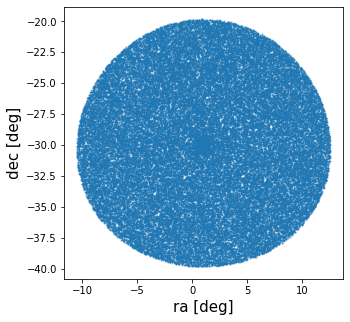

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

#plt.figure(figsize=(5,5))
#plt.scatter(df['pmra'], df['pmdec'], marker='o' , s=5, alpha = 0.5)
#plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 15)
#plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
#plt.show()

# Generate data

In [13]:
def pdf(x, mu, std):
    return 1/np.sqrt(2*np.pi*std**2) * np.exp(-(x-mu)**2 / (2*std**2))

def metropolis_hastings(x, mu, std, delta=0.1):
    x_new = x + (np.random.random()-0.5)*2.0*delta
    gamma = min(1, pdf(x_new, mu, std)/pdf(x, mu, std))
    alpha = np.random.random()
    if alpha < gamma:
        x = x_new
    return x

  0%|          | 0/30 [00:00<?, ?it/s]

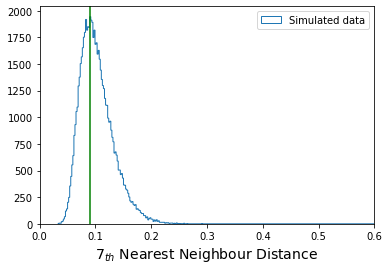

  3%|▎         | 1/30 [00:04<01:59,  4.14s/it]

0.08988322069082763


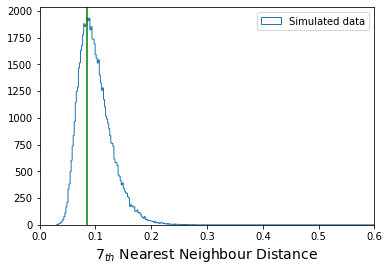

  7%|▋         | 2/30 [00:08<01:56,  4.15s/it]

0.08460575645711728


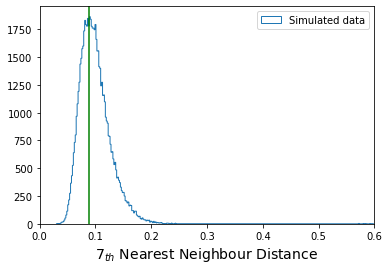

 10%|█         | 3/30 [00:12<01:51,  4.15s/it]

0.08922420512938496


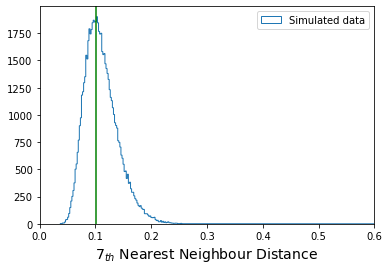

 13%|█▎        | 4/30 [00:16<01:45,  4.06s/it]

0.10184549315811552


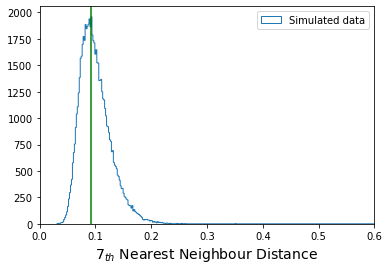

 17%|█▋        | 5/30 [00:20<01:45,  4.20s/it]

0.09208362957112196


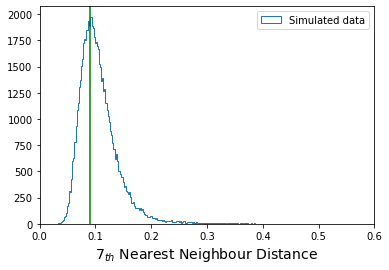

 20%|██        | 6/30 [00:24<01:40,  4.17s/it]

0.09125924162761886


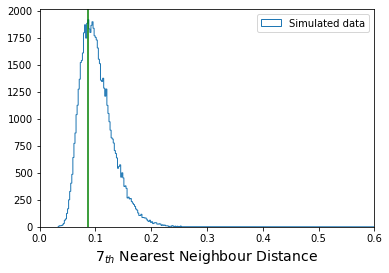

 23%|██▎       | 7/30 [00:28<01:34,  4.13s/it]

0.08631688807686294


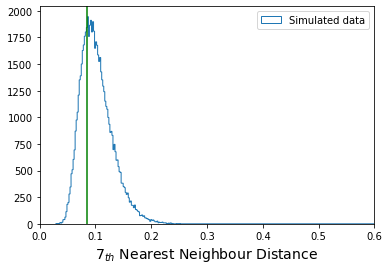

 27%|██▋       | 8/30 [00:32<01:30,  4.09s/it]

0.08570721385296484


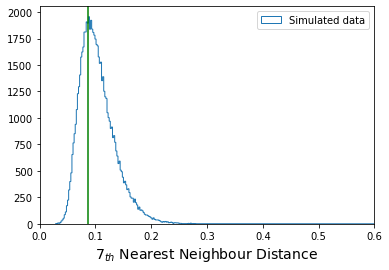

 30%|███       | 9/30 [00:36<01:24,  4.05s/it]

0.0874553634249283


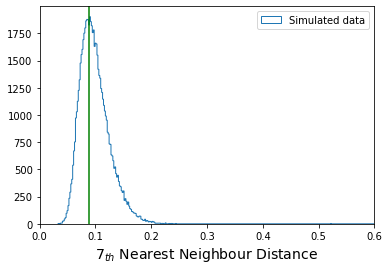

 33%|███▎      | 10/30 [00:41<01:21,  4.07s/it]

0.08944775992797593


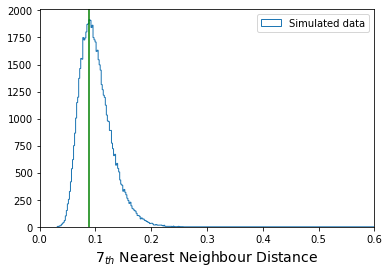

 37%|███▋      | 11/30 [00:45<01:17,  4.06s/it]

0.08843543320037128


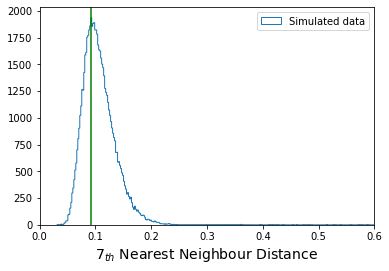

 40%|████      | 12/30 [00:49<01:12,  4.05s/it]

0.09163781262467804


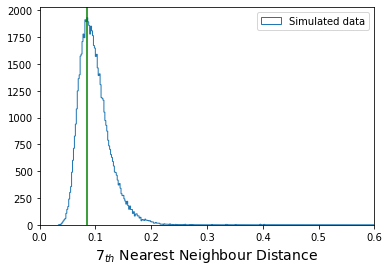

 43%|████▎     | 13/30 [00:53<01:11,  4.18s/it]

0.08460903075317563


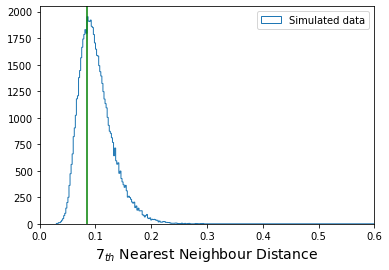

 47%|████▋     | 14/30 [00:57<01:06,  4.14s/it]

0.08501280893407741


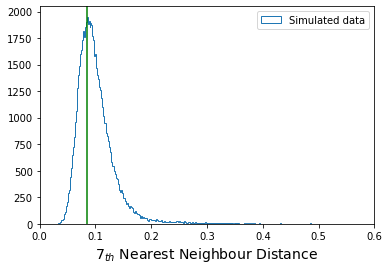

 50%|█████     | 15/30 [01:01<01:00,  4.06s/it]

0.08413989062301126


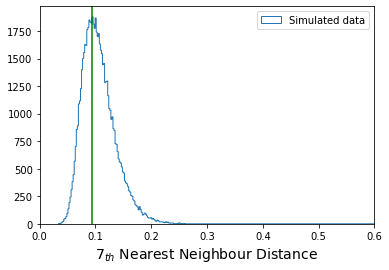

 53%|█████▎    | 16/30 [01:05<00:56,  4.02s/it]

0.0939929414214947


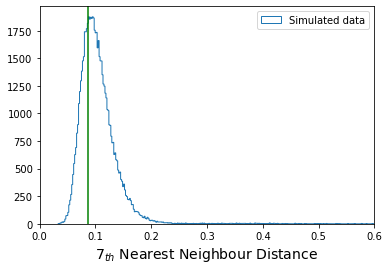

 57%|█████▋    | 17/30 [01:09<00:52,  4.05s/it]

0.08736873750222066


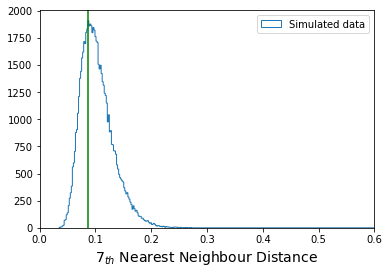

 60%|██████    | 18/30 [01:13<00:47,  3.99s/it]

0.08640809195021602


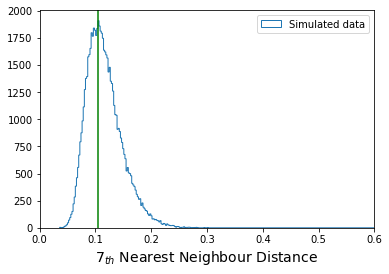

 63%|██████▎   | 19/30 [01:17<00:43,  3.93s/it]

0.10449772559879206


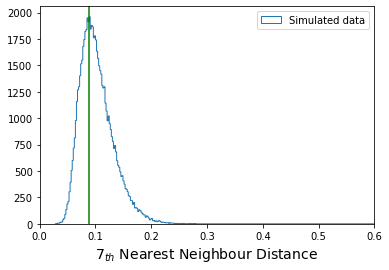

 67%|██████▋   | 20/30 [01:21<00:39,  3.96s/it]

0.08881802580363161


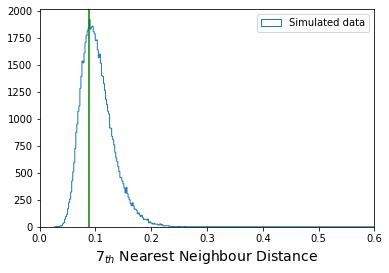

 70%|███████   | 21/30 [01:25<00:36,  4.04s/it]

0.08877027555888711


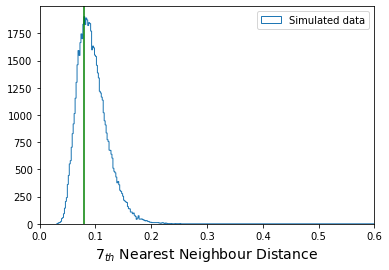

 73%|███████▎  | 22/30 [01:29<00:32,  4.06s/it]

0.07932066222459191


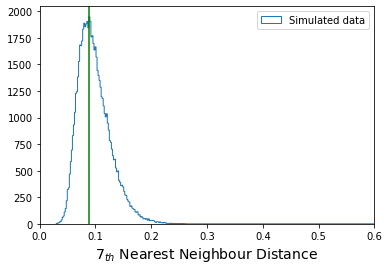

 77%|███████▋  | 23/30 [01:33<00:28,  4.03s/it]

0.08828363942581824


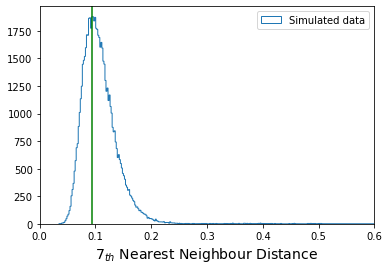

 80%|████████  | 24/30 [01:37<00:24,  4.11s/it]

0.09322721462296443


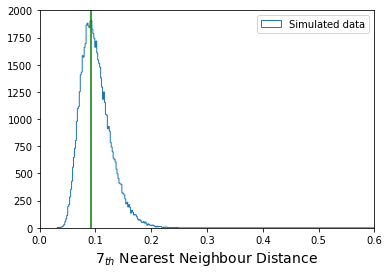

 83%|████████▎ | 25/30 [01:42<00:20,  4.15s/it]

0.09201406105309293


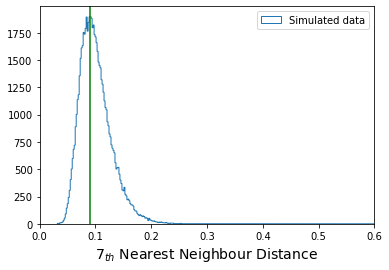

 87%|████████▋ | 26/30 [01:46<00:16,  4.19s/it]

0.09058369435457031


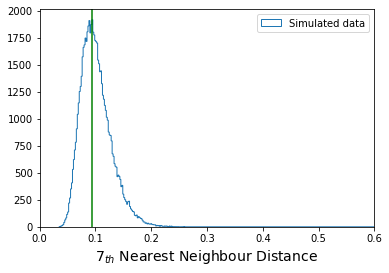

 90%|█████████ | 27/30 [01:50<00:12,  4.22s/it]

0.09364321030978318


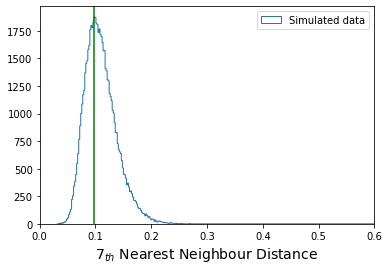

 93%|█████████▎| 28/30 [01:54<00:08,  4.18s/it]

0.09739932666210777


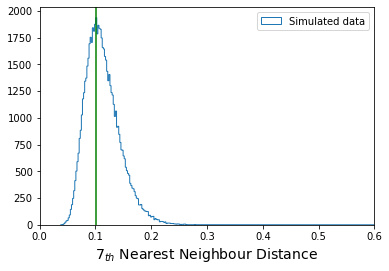

 97%|█████████▋| 29/30 [01:58<00:04,  4.13s/it]

0.1005044397130444


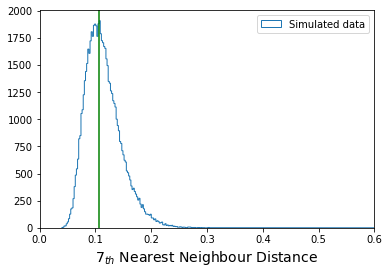

100%|██████████| 30/30 [02:02<00:00,  4.09s/it]

0.10670795975710506


In [14]:
eps_simulated = []
for k in tqdm(range(0,30)):
    names = ['ra','dec','pmra','pmdec','parallax']
    simulated_data = []
    for i in names:
        n_iteraciones = len(df[i])
        random_data = np.ones(n_iteraciones)
        mu, std = np.mean(df[i]), np.std(df[i])
        for j in range(1, n_iteraciones):
            random_data[j] = metropolis_hastings(random_data[j-1], mu, std, delta=1)
        simulated_data.append(random_data)
        random_teorico = np.linspace(min(random_data), max(random_data), len(df[i]))
        p_random_teorico = pdf(random_teorico, mu, std)

        #plt.hist(random_data, bins=50, density=True,alpha=0.5, label='Simulated data',histtype=u'step')
        #plt.plot(random_teorico, p_random_teorico, label='PDF')
        #plt.xlabel(i, fontsize=14)
        #plt.ylabel('Frequency',fontsize=14)
        #if i=='parallax':
        #    plt.xlim(0,5)
        #plt.legend()
        #plt.show()

    df_simulated = pd.DataFrame(np.array(simulated_data).transpose(), columns=['ra', 'dec','pmra','pmdec','parallax'])
    df_simulated = df_simulated.astype('float32')
    df_simulated = StandardScaler().fit(df_simulated).transform(df_simulated)

    neigh = NearestNeighbors(n_neighbors = 7, algorithm = 'kd_tree', n_jobs=8).fit(df_simulated)
    distances_simulated, indices = neigh.kneighbors(df_simulated)
    distances_simulated = np.sort(np.mean(distances_simulated, axis = 1))
    hist, bin_edges = np.histogram(distances_simulated, bins='auto',range=(min(distances_simulated),max(distances_simulated)))
    i = hist.argmax()

    #eps_simulated.append(min(distances_simulated))
    eps_simulated.append(bin_edges[i])
    
    #plt.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step')
    plt.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
    plt.xlabel(r'$7_{th}$ Nearest Neighbour Distance ', fontsize=14)
    plt.xlim(0,0.6)
    plt.axvline(eps_simulated[k],c='green')
    plt.legend()
    plt.show()
    print(eps_simulated[k])

In [15]:
np.savetxt('./blanco1_eps_simulated.txt', eps_simulated, delimiter=',')
eps_simulated

[0.08988322069082763,
 0.08460575645711728,
 0.08922420512938496,
 0.10184549315811552,
 0.09208362957112196,
 0.09125924162761886,
 0.08631688807686294,
 0.08570721385296484,
 0.0874553634249283,
 0.08944775992797593,
 0.08843543320037128,
 0.09163781262467804,
 0.08460903075317563,
 0.08501280893407741,
 0.08413989062301126,
 0.0939929414214947,
 0.08736873750222066,
 0.08640809195021602,
 0.10449772559879206,
 0.08881802580363161,
 0.08877027555888711,
 0.07932066222459191,
 0.08828363942581824,
 0.09322721462296443,
 0.09201406105309293,
 0.09058369435457031,
 0.09364321030978318,
 0.09739932666210777,
 0.1005044397130444,
 0.10670795975710506]

# K Nearest Neighbour Distance

In [4]:
data = df[['ra','dec','pmra','pmdec','parallax']]
data = data.astype('float32')
data = StandardScaler().fit(data).transform(data)

neigh = NearestNeighbors(n_neighbors=7, algorithm = 'ball_tree',n_jobs=4).fit(data)
distances, indices = neigh.kneighbors(data)
distances = np.sort(np.mean(distances, axis = 1))

eps_simulated = np.loadtxt('./blanco1_eps_simulated.txt')

hist, bin_edges = np.histogram(distances, bins='auto',range=(min(distances),max(distances)))
i = hist.argmax()
max_value = bin_edges[i]
average_eps_simulated = np.average(eps_simulated)
average_distance = np.average(distances)
print(average_eps_simulated)

0.09077345846701841


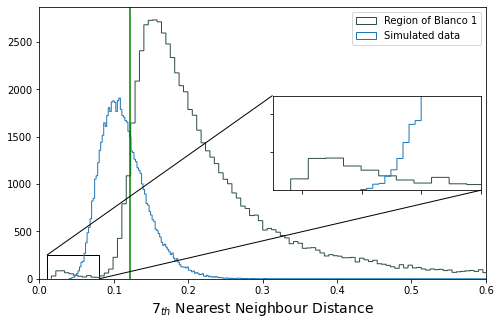

In [21]:
fig, ax = plt.subplots(figsize=[8, 5]) # create a new figure with a default 111 subplot
#plt.subplots_adjust(bottom = 0.15)
ax.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step',color='darkslategray')
ax.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
plt.xlabel(r'$7_{th}$ Nearest Neighbour Distance ', fontsize=14)
plt.xlim(0,0.6)
#plt.axvline(average_eps_simulated, label=r'Simulated $\epsilon=$ {:.09}'.format(0.11623179806790337),c='cyan')
#plt.axvline(max_value, label=r'7NND $\epsilon=$ {:.09}'.format(max_value),c='green')
plt.axvline((max_value+average_eps_simulated)/2,c='green')
plt.legend()

axins = zoomed_inset_axes(ax, 4, loc = 7) # zoom-factor: 2.5, location: upper-left
axins.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step',color='darkslategray')#x1, x2, y1, y2 = 14, 24, -3, 7 # specify the limits
axins.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
x1, x2, y1, y2 = 0.01, 0.08, 0.010, 250
axins.set_xlim(x1, x2) 
axins.set_ylim(y1, y2) 
plt.yticks(visible = False)
plt.xticks(visible = False)
mark_inset(ax, axins, loc1 = 2, loc2 = 4, fc = "white", ec = "black", linewidth = 1)
#axins.grid()
axins.spines['bottom'].set_color('black')
axins.spines['top'].set_color('black')
axins.spines['right'].set_color('black')
axins.spines['left'].set_color('black')
#plt.savefig('./knnd.png',bbox_inches='tight')

In [5]:
print('max_value:',max_value)
print('Average eps simulated:',average_eps_simulated)
eps = (average_eps_simulated + max_value)/2
print('eps:',eps)

max_value: 0.1521946811932906
Average eps simulated: 0.09077345846701841
eps: 0.1214840698301545


# DBSCAN

In [6]:
db = DBSCAN(eps = eps, min_samples = 8, n_jobs = 8, algorithm='ball_tree').fit(data)
labels = db.labels_ 
df['Clusters'] = labels
for i in list(set(labels)):
    print('{} {}'.format(i,len(df[(df['Clusters'] == i)])))

0 8
1 8
2 481
-1 65957


In [24]:
#for i in list(set(labels)):
#    if len(df[(df['Clusters'] == i)]) > 50:
#        print('{} {}'.format(i,len(df[(df['Clusters'] == i)])))

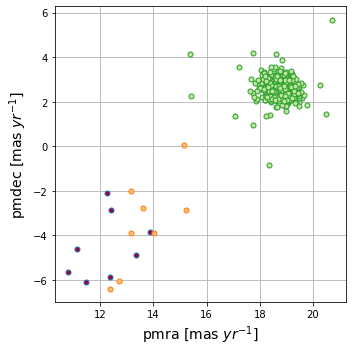

In [15]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if not i == -1:# or i == 0:
        plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
#else:
        #plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
        # color = 'black', marker='o' ,linestyle = 'None', markersize = 5, alpha = 1)
        #plt.scatter(0,0,marker='.')
plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)
plt.tight_layout()
plt.grid()
plt.savefig('./dbscan_images/blanco1_vpd_dbscan_complete.jpg',bbos_inches='tight')
plt.show() #should be on pmra(-26,-16) and pmdec(10,20)

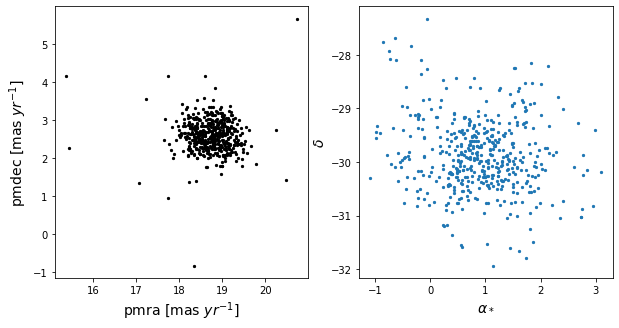

In [8]:
n = 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(df['pmra'][(df['Clusters'] == n)], df['pmdec'][(df['Clusters'] == n)], 
             color = 'black', marker='o' , s = 5, alpha = 1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)

plt.subplot(1,2,2)
plt.scatter(df['ra'][(df['Clusters'] == n)], df['dec'][(df['Clusters'] == n)], marker='o' , s=5, alpha = 1)
plt.xlabel(r'$\alpha_*$',fontsize = 14)
plt.ylabel(r'$\delta$',fontsize = 14)
plt.show()

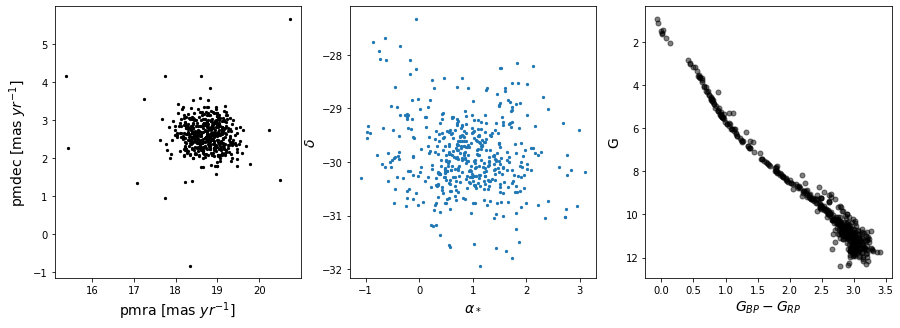

In [9]:
n = 2
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df['pmra'][(df['Clusters'] == n)], df['pmdec'][(df['Clusters'] == n)], 
             color = 'black', marker='o' , s = 5, alpha = 1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)

plt.subplot(1,3,2)
plt.scatter(df['ra'][(df['Clusters'] == n)], df['dec'][(df['Clusters'] == n)], marker='o' , s=5, alpha = 1)
plt.xlabel(r'$\alpha_*$',fontsize = 14)
plt.ylabel(r'$\delta$',fontsize = 14)

g_mag = df['g'][(df['Clusters'] == n)] + 5 - 5*np.log10(1/df['parallax'][(df['Clusters'] == n)])
color = df['bp'][(df['Clusters'] == n)] - df['rp'][(df['Clusters'] == n)]
plt.subplot(1,3,3)
plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
plt.gca().invert_yaxis()
#plt.savefig('./vpd.jpg')
plt.show()

In [10]:
df_test = df[(df['Clusters'] == n)]
df_test.to_csv('./blanco1_dbscan.csv')

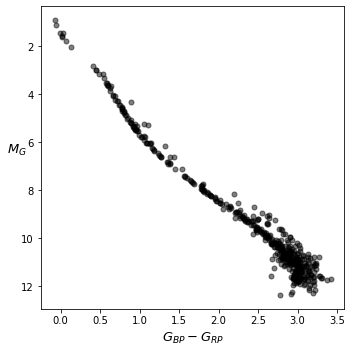

In [13]:
cluster = pd.read_csv('./blanco1_dbscan.csv')

plt.figure(figsize=(5,5))
plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 13)
plt.ylabel(r"$M_G$", fontsize = 13, rotation=0)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./dbscan_images/blanco1_cmd_dbscan.jpg',bbos_inches='tight')
plt.show()

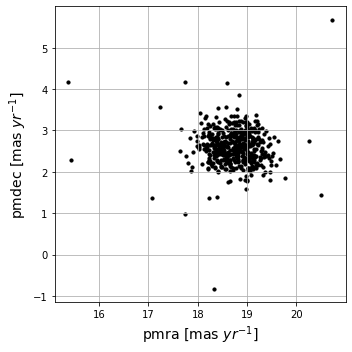

In [14]:
plt.figure(figsize=(5,5))
plt.grid()
plt.scatter(df['pmra'][(df['Clusters']==n)],df['pmdec'][(df['Clusters']==n)],color='black',marker='o',s=10,alpha=1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)
plt.tight_layout()
plt.savefig('./dbscan_images/blanco1_vpd_dbscan.jpg',bbos_inches='tight')
plt.show()